#Vehicle Movement Analysis and Insight Generation in a College Campus using Edge AI

In [ ]:
!pip install pytesseract
import pytesseract

In [ ]:
!apt-get install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


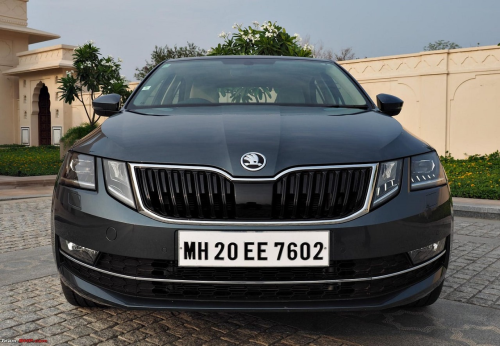

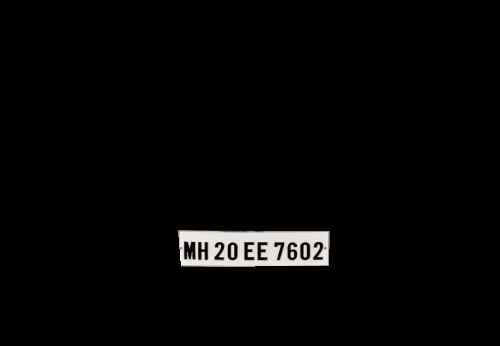

Image 1
MH 20 EE 7602




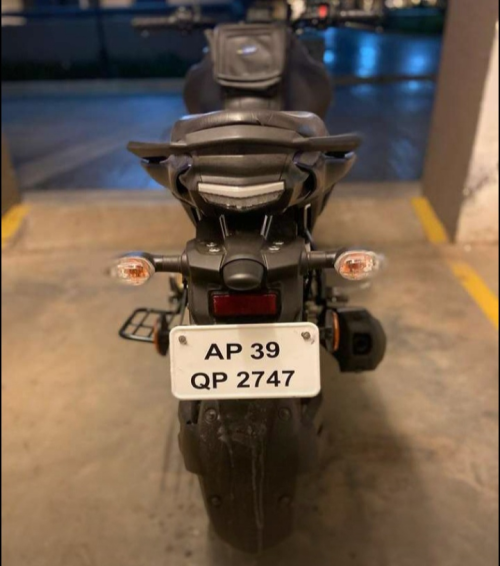

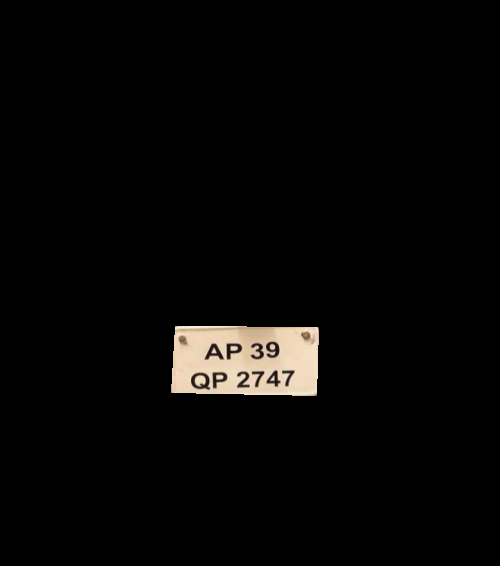

Image 2
AP 39
QP 2747




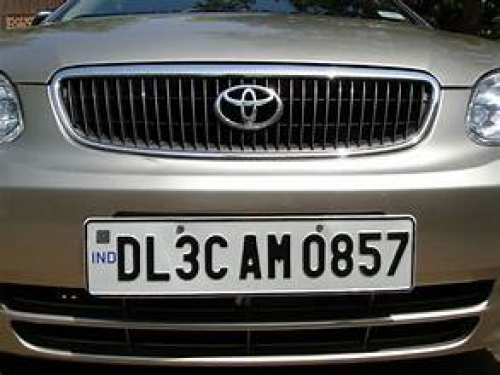

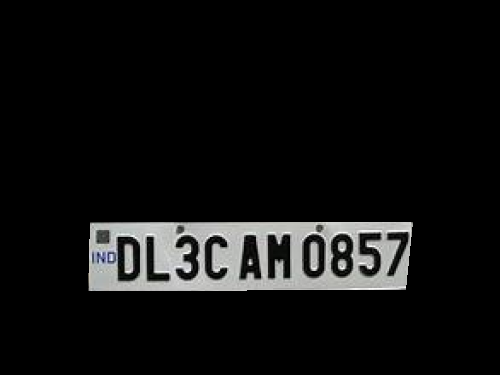

Image 3
"DL3C AM 0857,




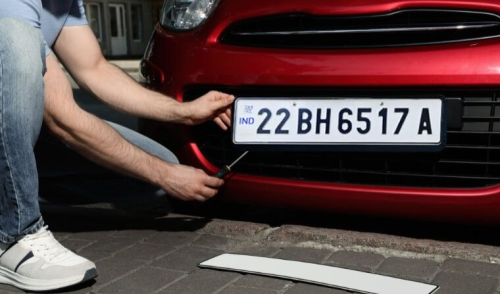

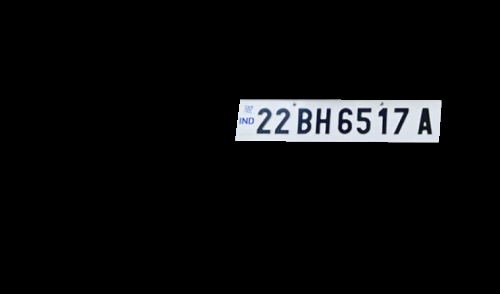

Image 4
22BH6517A




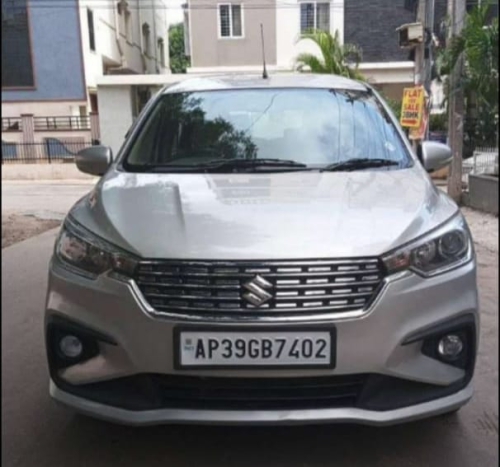

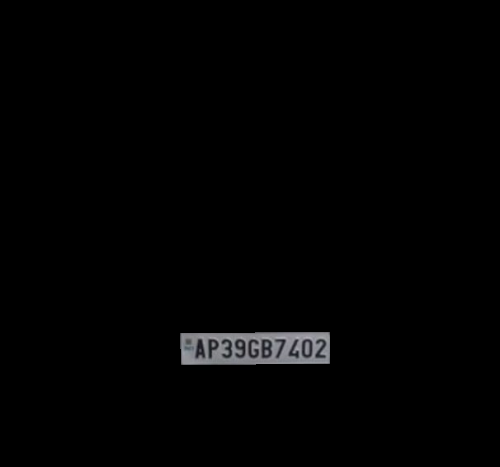

Image 5
AP39GB7402




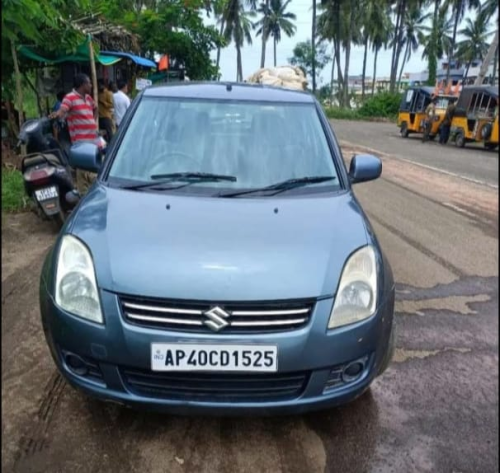

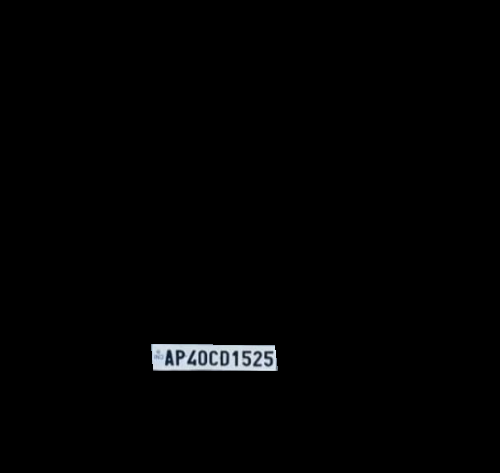

Image 6
AP40CD1525




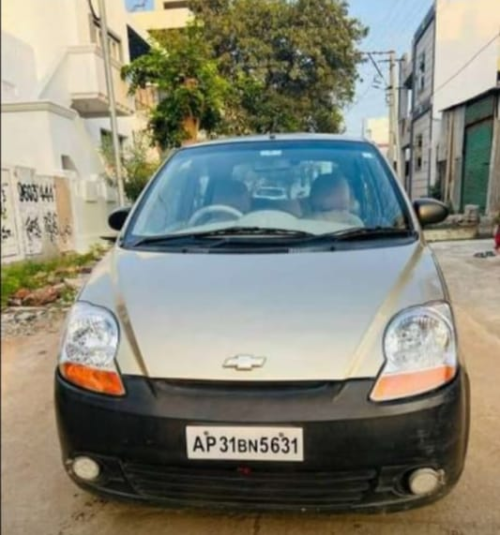

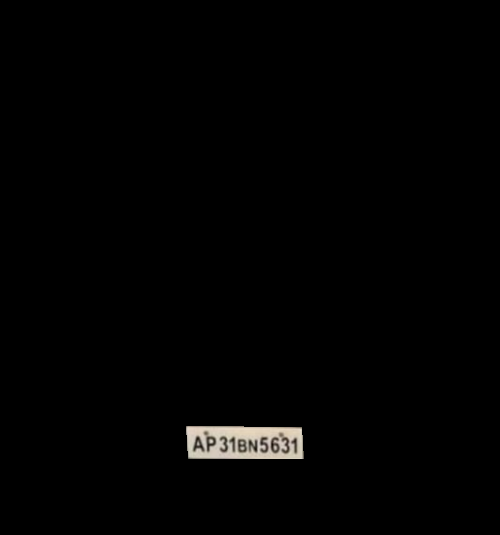

Image 7
AP 318N5631




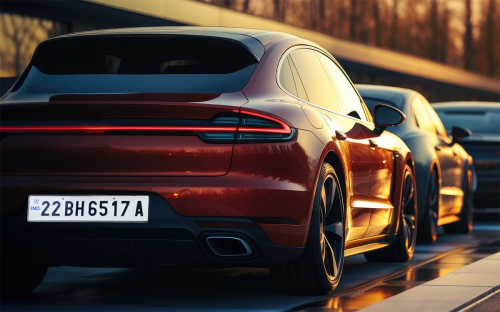

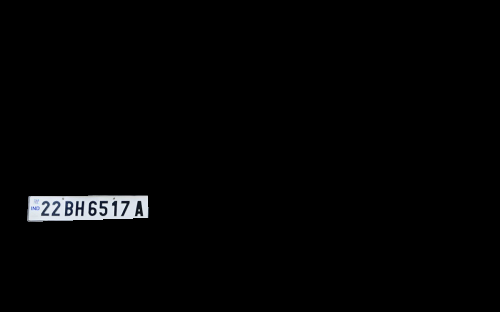

Image 8
22BH6517A




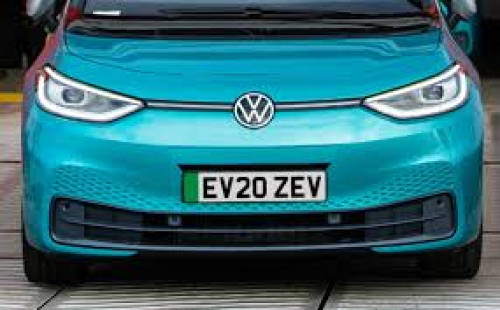

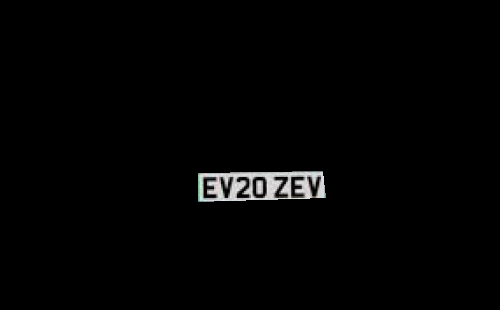

Image 9
EV20 ZEV




In [ ]:
import numpy as np
import os
import datetime
import cv2
import imutils
import pytesseract
import pandas as pd
import random as r
from google.colab.patches import cv2_imshow  # Importing cv2_imshow for displaying images

file_path = 'vehicles.csv'

for i in range(1, 10):
    image = cv2.imread(f'Images/vehicle{i}.jpg')

    if image is None:
        print(f"Image not found: Images/vehicle{i}.jpg")
        continue

    image = imutils.resize(image, width=500)
    cv2_imshow(image)  # Display the original image using cv2_imshow

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bilateralFilter(gray, 11, 17, 17)
    edged = cv2.Canny(gray, 170, 200)
    contours, _ = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:30]
    NumberPlateCnt = None
    for c in contours:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:
            NumberPlateCnt = approx
            break
    if NumberPlateCnt is None:
        print("Number plate not found")
        continue
    mask = np.zeros(gray.shape, np.uint8)
    new_image = cv2.drawContours(mask, [NumberPlateCnt], 0, 255, -1)
    new_image = cv2.bitwise_and(image, image, mask=mask)
    cv2_imshow(new_image)

    config = ('-l eng --oem 1 --psm 3')
    text = pytesseract.image_to_string(new_image, config=config)
    hh = r.randint(12, 19)
    mm = r.randint(15, 45)
    intime = f"{hh:02d}:{mm:02d}"
    hh_out = hh + r.randint(1, 3)
    mm_out = mm + r.randint(-6, 13)
    # Adjust for overflow
    if mm_out >= 60:
        hh_out += 1
        mm_out -= 60
    outtime = f"{hh_out:02d}:{mm_out:02d}"
    in_time_obj = datetime.datetime.strptime(intime, '%H:%M')
    out_time_obj = datetime.datetime.strptime(outtime, '%H:%M')
    total_time_obj = out_time_obj - in_time_obj
    total_time_minutes = total_time_obj.total_seconds()
    raw_data = {
        'Vehicle_Number': [text.strip()],
        'In_Time': [intime],
        'Out_Time': [outtime],
        'Total_Time': [total_time_minutes]
    }
    df = pd.DataFrame(raw_data, columns=['Vehicle_Number', 'In_Time', 'Out_Time','Total_Time'])
    if os.path.isfile(file_path):
        df.to_csv(file_path, mode='a', header=False, index=False)
    else:
        df.to_csv(file_path, mode='w', header=True, index=False)
    print(f"Image {i}")
    print(text)
    print()

Peak hour: 16:00 - 17:00
Number of vehicles: 4
Vehicles present during peak hour: ['"DL3C AM 0857,', 'AP39GB7402', 'AP40CD1525', '22BH6517A']

List of vehicles present in each hour:
00:00 - 01:00: No vehicles
01:00 - 02:00: No vehicles
02:00 - 03:00: No vehicles
03:00 - 04:00: No vehicles
04:00 - 05:00: No vehicles
05:00 - 06:00: No vehicles
06:00 - 07:00: No vehicles
07:00 - 08:00: No vehicles
08:00 - 09:00: No vehicles
09:00 - 10:00: No vehicles
10:00 - 11:00: No vehicles
11:00 - 12:00: No vehicles
12:00 - 13:00: ['AP 39\nQP 2747']
13:00 - 14:00: ['MH 20 EE 7602', 'AP 39\nQP 2747', 'EV20 ZEV']
14:00 - 15:00: ['MH 20 EE 7602', 'AP 318N5631', 'EV20 ZEV']
15:00 - 16:00: ['MH 20 EE 7602', '"DL3C AM 0857,', 'EV20 ZEV']
16:00 - 17:00: ['"DL3C AM 0857,', 'AP39GB7402', 'AP40CD1525', '22BH6517A']
17:00 - 18:00: ['22BH6517A', 'AP39GB7402', 'AP40CD1525']
18:00 - 19:00: ['AP39GB7402', 'AP40CD1525']
19:00 - 20:00: No vehicles
20:00 - 21:00: No vehicles
21:00 - 22:00: No vehicles
22:00 - 23:00: No

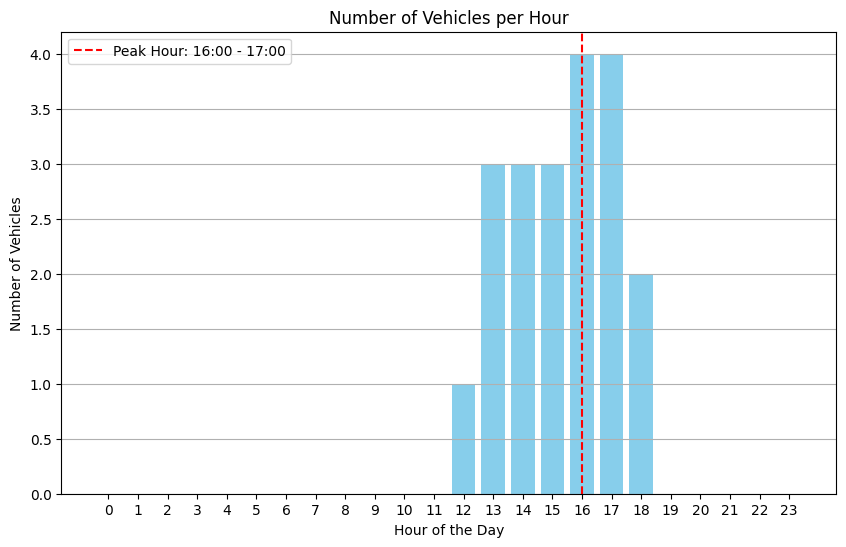

In [ ]:
import matplotlib.pyplot as plt
file_path = 'vehicles.csv'
df = pd.read_csv(file_path)
hourly_counts = {hour: 0 for hour in range(24)}
hourly_vehicles = {hour: [] for hour in range(24)}
for _, row in df.iterrows():
    in_time = datetime.datetime.strptime(row['In_Time'], '%H:%M')
    out_time = datetime.datetime.strptime(row['Out_Time'], '%H:%M')
    vehicle_number = row['Vehicle_Number']
    current_time = in_time
    while current_time < out_time:
        hourly_counts[current_time.hour] += 1
        if vehicle_number not in hourly_vehicles[current_time.hour]:
            hourly_vehicles[current_time.hour].append(vehicle_number)
        current_time += datetime.timedelta(hours=1)
        if current_time.minute < in_time.minute:
            current_time -= datetime.timedelta(minutes=current_time.minute)
            current_time += datetime.timedelta(hours=1)
peak_hour = max(hourly_counts, key=hourly_counts.get)
peak_count = hourly_counts[peak_hour]
print(f"Peak hour: {peak_hour:02d}:00 - {peak_hour+1:02d}:00")
print(f"Number of vehicles: {peak_count}")
print(f"Vehicles present during peak hour: {hourly_vehicles[peak_hour]}")
print("\nList of vehicles present in each hour:")
for hour in range(24):
    if hourly_vehicles[hour]:
        print(f"{hour:02d}:00 - {hour+1:02d}:00: {hourly_vehicles[hour]}")
    else:
        print(f"{hour:02d}:00 - {hour+1:02d}:00: No vehicles")
hours = list(hourly_counts.keys())
counts = list(hourly_counts.values())
plt.figure(figsize=(10, 6))
plt.bar(hours, counts, color='skyblue')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Vehicles')
plt.title('Number of Vehicles per Hour')
plt.xticks(hours)
plt.grid(axis='y')
plt.axvline(x=peak_hour, color='r', linestyle='--', label=f'Peak Hour: {peak_hour:02d}:00 - {peak_hour+1:02d}:00')
plt.legend()
plt.show()


**Parking Occupancy**

In [ ]:
rows = 5
cols = 10
parking_lot = np.zeros((rows, cols), dtype=object)
parking_times = np.zeros((rows, cols), dtype=object)
file_path = 'vehicles.csv'
df = pd.read_csv(file_path)
vehicle_names = df['Vehicle_Number'].tolist()
num_vehicles = min(len(vehicle_names), rows * cols)
available_positions = [(i, j) for i in range(rows) for j in range(cols)]
r.shuffle(available_positions)
for i in range(num_vehicles):
    position = available_positions[i]
    parking_lot[position] = vehicle_names[i]
    hh = r.randint(12, 19)
    mm = r.randint(15, 45)
    intime = f"{hh:02d}:{mm:02d}"
    parking_times[position] = f"In: {intime}"
df_parking_lot = pd.DataFrame(parking_lot, columns=[f"Spot {i+1}" for i in range(cols)])
df_parking_lot.index = [chr(65 + i) for i in range(rows)]
df_parking_times = pd.DataFrame(parking_times, columns=[f"Spot {i+1}" for i in range(cols)])
df_parking_times.index = [chr(65 + i) for i in range(rows)]
df_parking_lot.replace(0, 'Empty', inplace=True)
df_parking_times.replace(0, 'Empty', inplace=True)
df_combined = df_parking_lot.copy()
for row in df_combined.index:
    for col in df_combined.columns:
        if df_combined.loc[row, col] != 'Empty':
            df_combined.loc[row, col] += f" ({df_parking_times.loc[row, col]})"
output_file_path = 'parking_lot.csv'
df_combined.to_csv(output_file_path, index=True)